# ADS 509 Module 3: Group Comparison 

The task of comparing two groups of text is fundamental to textual analysis. There are innumerable applications: survey respondents from different segments of customers, speeches by different political parties, words used in Tweets by different constituencies, etc. In this assignment you will build code to effect comparisons between groups of text data, using the ideas learned in reading and lecture.

This assignment asks you to analyze the lyrics and Twitter descriptions for the two artists you selected in Module 1. If the results from that pull were not to your liking, you are welcome to use the zipped data from the “Assignment Materials” section. Specifically, you are asked to do the following: 

* Read in the data, normalize the text, and tokenize it. When you tokenize your Twitter descriptions, keep hashtags and emojis in your token set. 
* Calculate descriptive statistics on the two sets of lyrics and compare the results. 
* For each of the four corpora, find the words that are unique to that corpus. 
* Build word clouds for all four corpora. 

Each one of the analyses has a section dedicated to it below. Before beginning the analysis there is a section for you to read in the data and do your cleaning (tokenization and normalization). 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [1]:
import os
import re
import emoji
import pandas as pd

from collections import Counter, defaultdict
from nltk.corpus import stopwords
from string import punctuation
from wordcloud import WordCloud 

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer


In [2]:
# Use this space for any additional import statements you need
import glob


In [3]:
# Place any addtional functions or constants you need here. 
swi = stopwords.words("italian")
sws = stopwords.words("spanish")
swf = stopwords.words("french")

# Some punctuation variations
punctuation = set(punctuation) # speeds up comparison
tw_punct = punctuation - {"#"}

# Stopwords
sw = stopwords.words("english")

# Two useful regex
whitespace_pattern = re.compile(r"\s+")
hashtag_pattern = re.compile(r"^#[0-9a-zA-Z]+")

# It's handy to have a full set of emojis
all_language_emojis = set()

for country in emoji.UNICODE_EMOJI : 
    for em in emoji.UNICODE_EMOJI[country] : 
        all_language_emojis.add(em)

# and now our functions
def descriptive_stats(tokens, num_tokens = 5, verbose=True) :
    """
        Given a list of tokens, print number of tokens, number of unique tokens, 
        number of characters, lexical diversity, and num_tokens most common
        tokens. Return a list of 
    """

    # Place your Module 2 solution here
    num_tokens = len(tokens)
    num_unique_tokens = len(Counter(tokens))
    lexical_diversity = num_unique_tokens/num_tokens
    num_characters = sum([len(i) for i in tokens])
    
    if verbose :        
        print(f"There are {num_tokens} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")
    
        # print the five most common tokens
        print(Counter(tokens).most_common(5))
    return([num_tokens, num_unique_tokens,
            lexical_diversity,
            num_characters])

    
def is_emoji(s):
    return(s in all_language_emojis)

def contains_emoji(s):
    
    s = str(s)
    emojis = [ch for ch in s if is_emoji(ch)]

    return(len(emojis) > 0)


def remove_stop(tokens) :
    # modify this function to remove stopwords
    tokens = [i for i in tokens if i not in sw and i not in swi and i not in sws and i not in swf]
    return(tokens)
 
def remove_punctuation(text, punct_set=tw_punct) : 
    return("".join([ch for ch in text if ch not in punct_set]))

def tokenize(text) : 
    """ Splitting on whitespace rather than the book's tokenize function. That 
        function will drop tokens like '#hashtag' or '2A', which we need for Twitter. """
    # modify this function to return tokens
    text = text.split()
    return(text)

def prepare(text, pipeline) : 
    tokens = str(text)
    
    for transform in pipeline : 
        tokens = transform(tokens)
        
    return(tokens)


## Data Ingestion

Use this section to ingest your data into the data structures you plan to use. Typically this will be a dictionary or a pandas DataFrame.

In [4]:
# Feel fre to use the below cells as an example or read in the data in a way you prefer

data_location = "/Users/dallinmunger/Desktop/USD_Work/ADS 509/Module 1/" # change to your location if it is not in the same directory as your notebook
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

artist_files = {'bocelli':'AndreaBocelli_followers_data.txt',
                'groban':'joshgroban_followers_data.txt'}


In [5]:
twitter_data = pd.read_csv(data_location + twitter_folder + artist_files['bocelli'],
                           sep="\t",
                           quoting=3)

twitter_data['artist'] = "andreabocelli"

In [6]:
twitter_data_2 = pd.read_csv(data_location + twitter_folder + artist_files['groban'],
                             sep="\t",
                             quoting=3)
twitter_data_2['artist'] = "joshgroban"

twitter_data = pd.concat([
    twitter_data,twitter_data_2])
    
del(twitter_data_2)

In [7]:
# read in the lyrics here
artists = ['andreabocelli', 'joshgroban']
# Read in the lyrics data

# Create empty lists
songs = []
title = []
artist_name = []
for i in range(len(artists)):
    # Create path to files
    name = data_location + lyrics_folder + artists[i] + '/*.txt'
    # Read in all song files, add to list
    songs.append([open(filename).read() for filename in glob.glob(name)])
    # Extract title from the songs, add to list
    title.append([re.findall(r'"([^"]*)"', i) for i in songs[i]])
    # Create list of artist name
    artist_name.append([artists[i]]*len(songs[i]))
lyrics_data = pd.DataFrame()
title = title[0] + title[1]
lyrics_data['title'] = sum(title, [])
lyrics_data['artist'] = artist_name[0] + artist_name[1]
lyrics_data['lyrics'] = songs[0] + songs[1]

## Tokenization and Normalization

In this next section, tokenize and normalize your data. We recommend the following cleaning. 

**Lyrics** 

* Remove song titles
* Casefold to lowercase
* Remove punctuation
* Split on whitespace
* Remove stopwords (optional)

Removal of stopwords is up to you. Your descriptive statistic comparison will be different if you include stopwords, though TF-IDF should still find interesting features for you.

**Twitter Descriptions** 

* Casefold to lowercase
* Remove punctuation other than emojis or hashtags
* Split on whitespace
* Remove stopwords

Removing stopwords seems sensible for the Twitter description data. Remember to leave in emojis and hashtags, since you analyze those. 

In [8]:
# apply the `pipeline` techniques from BTAP Ch 1 or 5

my_pipeline = [str.lower, remove_punctuation, tokenize, remove_stop]

lyrics_data["tokens"] = lyrics_data["lyrics"].apply(prepare,pipeline=my_pipeline)
lyrics_data["num_tokens"] = lyrics_data["tokens"].map(len) 

twitter_data["tokens"] = twitter_data["description"].apply(prepare,pipeline=my_pipeline)
twitter_data["num_tokens"] = twitter_data["tokens"].map(len) 


In [9]:
twitter_data['has_emoji'] = twitter_data["description"].apply(contains_emoji)

Let's take a quick look at some descriptions with emojis.

In [10]:
twitter_data[twitter_data.has_emoji].sample(10)[["artist","description","tokens"]]

,artist,description,tokens
334,joshgroban,Retired RN. My Avatar is a portrait of healthc...,"[retired, rn, avatar, portrait, healthcare, wo..."
4506,andreabocelli,ci sono regole ritmi equilibri che non puoi to...,"[regole, ritmi, equilibri, puoi, toccare, cè, ..."
4404,andreabocelli,Christian Angel Ocean Baby 😇🌊🏝️ JESUS is my Sa...,"[christian, angel, ocean, baby, 😇🌊🏝️, jesus, s..."
2823,andreabocelli,➕❣️호떡❤️🖤JAZZ💙ㅅㅂ:)+🦐모하세오??¿🌸💭these 🌠dreams 🙈kee...,"[➕❣️호떡❤️🖤jazz💙ㅅㅂ🦐모하세오¿🌸💭these, 🌠dreams, 🙈keep,..."
2390,joshgroban,"💙#Resistance, proud Democrat, ready for the in...","[💙#resistance, proud, democrat, ready, indictm..."
4307,andreabocelli,Classical music 🎻🎶🐇 🐶 Stan tsv Violin gang and...,"[classical, music, 🎻🎶🐇, 🐶, stan, tsv, violin, ..."
1939,joshgroban,Common sense/Scot in England/biological sex ma...,"[common, sensescot, englandbiological, sex, ma..."
2247,andreabocelli,Autor de El Trino de un Cuervo YouTuber Twitte...,"[autor, trino, cuervo, youtuber, twittero, amo..."
4653,andreabocelli,عالمي الهوى💛💙,"[عالمي, الهوى💛💙]"
4755,joshgroban,🍁,[🍁]


With the data processed, we can now start work on the assignment questions. 

Q: What is one area of improvement to your tokenization that you could theoretically carry out? (No need to actually do it; let's not make perfect the enemy of good enough.)

A: The emojis could be separated from text so they stand alone. This would help with both emoji and word analysis.

## Calculate descriptive statistics on the two sets of lyrics and compare the results. 


In [11]:
# your code here
#Descriptive statistics for Andrea Bocelli lyrics
print("Andrea Bocelli Lyrics:")
descriptive_stats(sum(lyrics_data.loc[lyrics_data['artist'] == 'andreabocelli', 'tokens'], []))
print("\nJosh Groban Lyrics:")
#Descriptive statistics for Josh Groban lyrics
descriptive_stats(sum(lyrics_data.loc[lyrics_data['artist'] == 'joshgroban', 'tokens'], []))

Andrea Bocelli Lyrics:
There are 1712 tokens in the data.
There are 876 unique tokens in the data.
There are 9643 characters in the data.
The lexical diversity is 0.512 in the data.
[('vivo', 33), ('mai', 24), ('vita', 23), ('vivere', 22), ('amore', 15)]

Josh Groban Lyrics:
There are 1760 tokens in the data.
There are 834 unique tokens in the data.
There are 9536 characters in the data.
The lexical diversity is 0.474 in the data.
[('love', 21), ('say', 19), ('still', 18), ('youre', 18), ('lamore', 17)]


[1760, 834, 0.4738636363636364, 9536]

Q: what observations do you make about these data? 

A: The lexical diversity between the artists is very similar. "You're" also shows up, which could be due to the order of operations in the pipeline. Since punctuation was removed, "youre" would not show as a stop word to remove. "L'amore" is the same way, where normally the article "l'" (the) would be removed.


## Find tokens uniquely related to a corpus

Typically we would use TF-IDF to find unique tokens in documents. Unfortunately, we either have too few documents, if we view each data source as a single document, or too many, if we view each description as a separate document. In the latter case, our problem will be that descriptions tend to be short, so our matrix would be too sparse to support analysis. 

To get around this, we find tokens for each corpus that match the following criteria:

1. The token appears at least `n` times in all corpora
1. The tokens are in the top 10 for the highest ratio of appearances in a given corpora vs appearances in other corpora.

You will choose a cutoff for yourself based on the side of the corpus you're working with. If you're working with the Robyn-Cher corpora provided, `n=5` seems to perform reasonably well.


In [12]:
# your code here
# Combine all tokens into one list
all_tokens = sum(lyrics_data['tokens'].append(twitter_data['tokens']), [])
# Count unique occurrence of tokens
all_tokens_count = Counter(all_tokens)
# Place in a dataframe
all_tokens_df = pd.DataFrame.from_dict(all_tokens_count, orient = 'index', columns = ['count']).reset_index()
all_tokens_df = all_tokens_df = all_tokens_df.rename(columns = {'index':'tokens'})
# Filter by n >= 5
all_tokens_df = all_tokens_df[all_tokens_df['count'] > 10]

# Calculate ratio for all descriptions and output list of top tokens
def top_tokens(artist_name, new_col_name, ratio_col_name, df):
    corpus_count = Counter(sum(df.loc[df['artist'] == artist_name, 'tokens'], []))
    corpus_tokens = pd.DataFrame.from_dict(corpus_count, orient = 'index', columns = [new_col_name]).reset_index()
    corpus_tokens = corpus_tokens.rename(columns = {'index':'tokens'})
    combined_tokens = all_tokens_df.merge(corpus_tokens, on = 'tokens', how = 'left')
    combined_tokens = combined_tokens.fillna(0)
    # Store number of times token appears in current corpus, number of tokens in current corpus
    count_current = combined_tokens[new_col_name]
    corpus_length = len(sum(df.loc[df['artist'] == artist_name, 'tokens'], []))
    # Store number of times token appears in all other docs combined, number of tokens in all other docs
    other_count = combined_tokens['count'] - combined_tokens[new_col_name]
    total_length = len(all_tokens) - corpus_length
    # Calculate ratio of count in current doc to number of tokens. Then get ratio of other count to all other token count
    combined_tokens[ratio_col_name] = (count_current/corpus_length)/(other_count/total_length)
    top_list = combined_tokens.nlargest(10, [ratio_col_name])['tokens'].tolist()
    return(top_list)

# Andrea Bocelli Twitter
print('Andrea Bocelli Twitter Descriptions top tokens (by ratio):')
print(top_tokens('andreabocelli', 'bocelli_twitter_counts', 'bocelli_twitter_ratio', twitter_data))
# Josh Groban Twitter
print('\nJosh Groban Twitter Descriptions top tokens (by ratio):')
print(top_tokens('joshgroban', 'groban_twitter_counts', 'groban_twitter_ratio', twitter_data))
# Andrea Bocelli Lyrics
print('\nAndrea Bocelli Lyrics top tokens (by ratio):')
print(top_tokens('andreabocelli', 'bocelli_lyrics_counts', 'bocelli_lyrics_ratio', lyrics_data))
#Josh Groban Lyrics
print('\nJosh Groban Lyrics top tokens (by ratio):')
print(top_tokens('joshgroban', 'groban_lyrics_counts', 'groban_lyrics_ratio', lyrics_data))


Andrea Bocelli Twitter Descriptions top tokens (by ratio):
['،', 'في', 'fc', 'من', 'cantante', 'vivir', 'mejor', 'q', 'corazón', 'arte']

Josh Groban Twitter Descriptions top tokens (by ratio):
['hehimhis', 'theater', 'josh', 'broadway', 'need', 'youtube', 'write', 'actress', 'theatre', 'playing']

Andrea Bocelli Lyrics top tokens (by ratio):
['poi', 'nun', 'vivere', 'così', 'ah', 'vivo', 'mare', 'maria', 'bene', 'forse']

Josh Groban Lyrics top tokens (by ratio):
['girera', 'lamore', 'vai', 'luce', 'fall', 'sento', 'senza', 'youre', 'hear', 'cuore']


Q: What are some observations about the top tokens? Do you notice any interesting items on the list? 

A: The Andrea Bocelli Twitter tokens are interesting because there are not really any English phrases or words. It's all other languages or symbols. The Josh Groban Twitter tokens, in contrast, are primarily English. The lyrics tokens are also similar, in that Josh Groban lyrics have some English scattered with Italian, and Andrea Bocelli lyrics are primarily Italian. This would be expected based on their native languages. 

## Build word clouds for all four corpora. 

For building wordclouds, we'll follow exactly the code of the text. The code in this section can be found [here](https://github.com/blueprints-for-text-analytics-python/blueprints-text/blob/master/ch01/First_Insights.ipynb). If you haven't already, you should absolutely clone the repository that accompanies the book. 


In [13]:
from matplotlib import pyplot as plt

def wordcloud(word_freq, title=None, max_words=200, stopwords=None):

    wc = WordCloud(width=800, height=400, 
                   background_color= "black", colormap="Paired", 
                   max_font_size=150, max_words=max_words)
    
    # convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items() 
                              if token not in stopwords}
    wc.generate_from_frequencies(counter)
 
    plt.title(title) 

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    
    
def count_words(df, column='tokens', preprocess=None, min_freq=2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    df[column].map(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)

Andrea Bocelli Twitter Wordcloud:


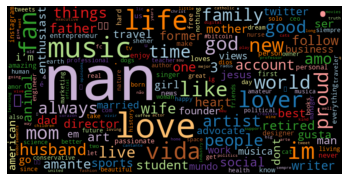

In [14]:
# Count words
bocelli_twitter_count = count_words(twitter_data[twitter_data['artist'] == 'andreabocelli'])
groban_twitter_count = count_words(twitter_data[twitter_data['artist'] == 'joshgroban'])
bocelli_lyrics_count = count_words(lyrics_data[lyrics_data['artist'] == 'andreabocelli'])
groban_lyrics_count = count_words(lyrics_data[lyrics_data['artist'] == 'joshgroban'])

#Create wordclouds
print('Andrea Bocelli Twitter Wordcloud:')
wordcloud(bocelli_twitter_count.squeeze())


Josh Groban Twitter Wordcloud:


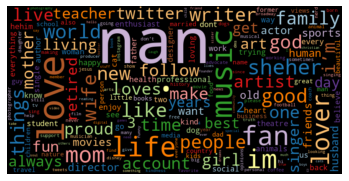

In [15]:
print('\nJosh Groban Twitter Wordcloud:')
wordcloud(groban_twitter_count.squeeze())

Andrea Bocelli Lyrics Wordcloud:


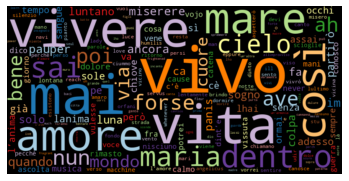

In [16]:
print('Andrea Bocelli Lyrics Wordcloud:')
wordcloud(bocelli_lyrics_count.squeeze())

Josh Groban Lyrics Wordcloud:


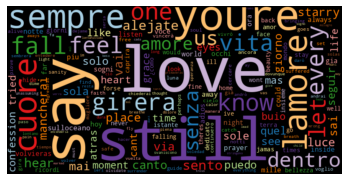

In [17]:
print('Josh Groban Lyrics Wordcloud:')
wordcloud(groban_lyrics_count.squeeze())

Q: What observations do you have about these (relatively straightforward) wordclouds? 

A: The Twitter wordclouds have a lot of missing values, indicating missing descriptions. The lyrics indicate some common themes in songs, with variations of the word "love" used frequently for Josh Groban and "live" (vivo, vivere) for Andrea Bocelli.